<a href="https://colab.research.google.com/github/armlabstanford/robotics_primer_tutorials/blob/master/Machine_Learning_Primer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

# Machine Learning Primer

Machine learning is a powerful tool, but is often not well understood. It is the hope of this basic tutorial just to give you highlevel concept/programming examples and is by **no means holistic**. The fundamental principle of machine learning methods are that '*close* inputs correspond to *close* outputs', the subtlty lies in this notion of 'closeness' and formally can be written as: 

![](https://raw.githubusercontent.com/armlabstanford/robotics_primer_tutorials/master/imgs/machine_learning_basic_principle.png)

The book **Christopher M. Bishop, "Pattern Recognition and Machine Learning", Springer, 2006.** is highly recommended.

Often machine learning techniques are used for classification or model approximation (regression). When dealing with real-world data (not generated from clean analytical models) we may find that *statistically* the data follows a particular model, and we want our machine learning modeling technique to capture this.

![](https://raw.githubusercontent.com/armlabstanford/robotics_primer_tutorials/master/imgs/ML_classification_vs_model_approx.png)

We will outline two machine learning model regression approaches.

## Gaussian Process for Model Regression

The Gaussian Process (GP) is one of the most intuitive machine learning techniques as there are few 'control handles' needed to setup, train and test the model. The GP relies on the principle that *close* inputs relate to *close* inputs explicitly with the use of the Gaussian kernel. With the kernel, covariance matricies are constructed which relate the closeness of training inputs/outputs: $(x,y)$, and test points $x^*$ and *expected outputs:* $y^*$. The key here is that the model is *non-parameteric*, meaning that given enough training points that adaquately sample the space (given the kernel parameters), the GP is capable of estimating the inliers in the space *and* can assess its confidence with the output covariance $V$

![](https://raw.githubusercontent.com/armlabstanford/robotics_primer_tutorials/master/imgs/GP_process.png)

The book **Rasmussen, Carl E., and Christopher K. Williams. "Gaussian processes for machine learning". Cambridge, Mass: MIT Press, 2006.** is highly recommended.

Another interactive toy example:
https://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/basic_gp.ipynb


![](https://raw.githubusercontent.com/armlabstanford/robotics_primer_tutorials/master/imgs/gp5pts.png)
![](https://raw.githubusercontent.com/armlabstanford/robotics_primer_tutorials/master/imgs/gp20pts.png)


Below you will find the code used to generate the $y=a \cdot sin(b \cdot x+c) + d$ example above. Note that the GP is fully implemented here, but there is a library that can be used instead: GPy (https://gpy.readthedocs.io/en/deploy/) or https://pygp.readthedocs.io/en/latest/

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt #for plotting just like in matlab
from matplotlib import animation, rc #this will be used to play animations
# rc('text', usetex=True) #if you want to use latex in plot legends
rc('animation', html='jshtml')
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

class GPExample(object):
  """docstring for GPExample
    This is a simple script that demos the abilities of the GP on a simple 2D example of a sine curve  
  """
  def __init__(self, a=1,b=1,c=0,d=0, num_training_pts=20, training_data_span=[0,10]):
    self.x_train = np.linspace(training_data_span[0], training_data_span[1], num_training_pts)
    self.y_train = a*np.sin(b*self.x_train + c ) + d
    #turn these into matricies
    self.x_train = np.matrix(self.x_train).T  #these were lists, defaults to row vector, make coloumn
    self.y_train = np.matrix(self.y_train).T

    self.K_train = None  #covariance matrix for training data
    self.alpha_vect = None  #decision vector soley based on training data
    self.sigma = 1e-1  #this is to help when covariance is very small with inversion

  def kernel_function(self,xp=0,xq=0):
    #defines Gaussian kernel function: k(xp,xq) = exp(-(0.5)(xp-xq).T(xp-xq))
    #first check that size and dim are the same else print error and return 0
    kern = 0 #default kernel value
    if type(xp) != type(xq):
      #this is the case when you want to get a kernel vector or non-square type, but make them both the same type (e.g matrix)
      print("types are wrong")
    if type(xp) == np.matrixlib.defmatrix.matrix and type(xq) == np.matrixlib.defmatrix.matrix:
      if np.min(xp.shape) == 1 and np.min(xq.shape) == 1:
        #make sure they have the same orientation
        if xp.shape[0] == 1: xp = xp.T
        if xq.shape[0] == 1: xq = xq.T
        #calculate the kernel
        kern = np.zeros([np.max(xp.shape),np.max(xq.shape)])  #non-square kernel
        for idx in range(np.max(xp.shape)):
          for jdx in range(np.max(xq.shape)):
            kern[idx,jdx] = np.exp(-0.5*(xp.item(idx)-xq.item(jdx))**2)
      else:
        print("vectors (nx1) were not passed")
        #need a vector
    else:
      #this assumes xp, xq are both scalars
      kern = np.exp(-0.5*(xp-xq)**2)
    #Return the kernel
    kern = np.matrix(kern)
    return kern

  def obtain_K_train(self):
    #obtain the training covariance
    self.K_train = self.kernel_function(self.x_train, self.x_train) #this uses the kernel to establish positional relationship between the training data points

  def obtain_alpha(self):
    #This is the decision vector: alpha = (K+s*I)^{-1} y_train
    K = self.K_train
    self.alpha_vect = np.linalg.inv(K + self.sigma**2*np.eye(np.max(K.shape)))*self.y_train

  def generate_test_points(self,num_test_pts=20,test_data_span=[0,9.5]):
    #generate test points, this can be reduced to a single test point if desired
    self.x_test = np.matrix(np.linspace(test_data_span[0], test_data_span[1], num_test_pts)).T

  def evaluate_test_points(self):
    #Evaluate the test points to find y_test, Ky_test (mean and variance with each test point)
    #1. find the kernel vector with the training data
    K_s = self.kernel_function(xp=self.x_train, xq=self.x_test)
    K_ss = self.kernel_function(xp=self.x_test, xq=self.x_test)
    #Check their dimensions
    #print("\nK_s shape:", K_s.shape, "\nK_ss shape:", K_ss.shape)
    #print("\nKs, ", K_s, "\n K_ss", K_ss, ", K_ss det: ", np.linalg.det(K_ss))
    #2. Find f = Ks^T*(K+s*I)^{-1} y
    self.y_test = K_s.T * self.alpha_vect
    #print("y_test", self.y_test)
    #3. Find V[f] (covariance): Kss - Ks^T (K + s*I)^{-1} Ks
    K = self.K_train
    #print("\nKss shape", K_ss.shape, " Ks shape", K_s.shape, "\ndet Kss", np.linalg.det(K_ss))
    self.cov_test = K_ss - K_s.T*np.linalg.inv(K + self.sigma*np.eye(np.max(K.shape)))*K_s
    #This too should have expected covariance properties
    cov_sym = self.cov_test - self.cov_test.T
    #print("cov_test det:", np.linalg.det(self.cov_test), " V^T-V max/min values:", np.max(cov_sym), np.min(cov_sym))

  def display_GP_output(self,num_training_pts=0):
    fig = plt.figure(figsize=(15,10))
    ax = fig.gca()
    #Plot the training data
    train_data = ax.plot(self.x_train.T.tolist()[0], self.y_train.T.tolist()[0],label="training data")
    train_data_scatter = ax.scatter(self.x_train.T.tolist()[0], self.y_train.T.tolist()[0],label="training data scatter")
    #Plot the mean test data
    test_data_mean = ax.scatter(self.x_test.T.tolist()[0],self.y_test.T.tolist()[0],label="test data mean")
    #Plot the associated covariance with the test data, realize that the associated covariance with each point is the diagonal elements of V[f]
    Vtt = [self.cov_test[idx,idx] for idx in range(self.cov_test.shape[0])]
    x = self.x_test.T.tolist()[0]
    y = self.y_test.T.tolist()[0]
    upper = [y[idx]+Vtt[idx] for idx in range(len(y))]
    lower = [y[idx]-Vtt[idx] for idx in range(len(y))]
    test_data_mean_cov = ax.fill_between(x,lower,upper, alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
    ax.legend(fontsize=15)
    ax.set_xlabel('x',fontsize=40)
    ax.set_ylabel('$y=sin(x)$',fontsize=40)
    
    fig.suptitle("Number of training points: %s"%num_training_pts,fontsize=40)
    # plt.show()

Now let's test this:

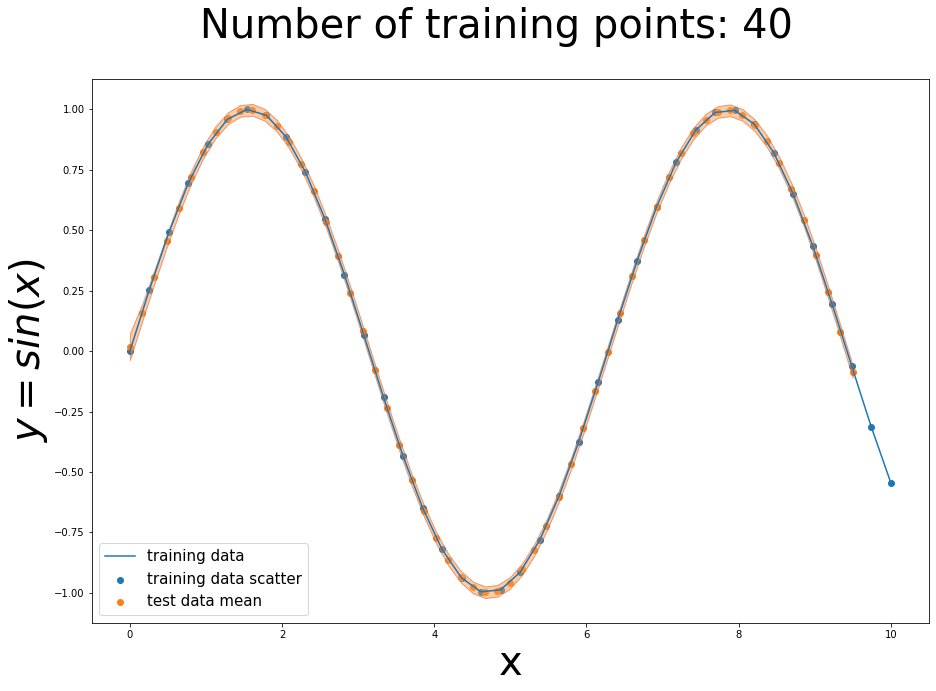

In [3]:
a = 1; b = 1; c = 0; d = 0;
num_training_pts = 40 #How many training points do you want to select?
data_span = [0,10]  #x in [xs,xf]
#generate class object
cls_obj = GPExample(a=a,b=b,c=c,d=d, num_training_pts=num_training_pts, training_data_span=data_span)
#Use training data to make covariance matrix
cls_obj.obtain_K_train()
#Then find the decision vector alpha
cls_obj.obtain_alpha()
#Generate the testpoints (feel free to update the default params)
cls_obj.generate_test_points(num_test_pts=60)
#Evaluate the test points (their mean and covariance w.r.t. the training data)
cls_obj.evaluate_test_points()
#Print the output
cls_obj.display_GP_output(num_training_pts=num_training_pts)
# plt.show()

## Neural Nets for Regression

Neural Nets are a powerful tool. There are many renditions, but here in this simple primer we will focus on feed-forward neural networks. A key concept is the Universal Approximation Theorem:

![](https://raw.githubusercontent.com/armlabstanford/robotics_primer_tutorials/master/imgs/UAT.png)

![](https://raw.githubusercontent.com/armlabstanford/robotics_primer_tutorials/master/imgs/activation_function.png)
For this example we will use the following 2-layer feed-forward network: 
![](https://raw.githubusercontent.com/armlabstanford/robotics_primer_tutorials/master/imgs/NN_simple_example.png)

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import random

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import animation, rc #this will be used to play animations
# rc('text', usetex=True) #if you want to use latex in plot legends



In [5]:
#In this block generate the dataset for a linear system
class Dynamical_System_dataset(object):
    def __init__(self,A=None):
        if type(A)==type(None):
            A = -np.matrix(np.eye(2))
        self.A = A
        self.training_data = {'inputs':[],'outputs':[]}
        
    def select_model(self,curr_input, model_type="nonlinear"):
        #make whatever model you would like here:
        if  model_type in "linear_1":
            A = np.matrix([[-1,0],[0,-1]])
            dx = A*curr_input
        elif model_type in "linear_2":
            A = np.matrix([[-1,0],[0,-1]])
            dx = A*curr_input            
        if model_type in "nonlinear":
            #nonlinear model:
            x1 = curr_input.item(0)
            x2 = curr_input.item(1)
            dx = np.matrix([x2-0.5*x1 ,np.sin(x1)]).T
        else:
            print("please specify desired model or make a new one")
        return dx
    
    def generate_training_data(self,x1lim=[],x2lim=[]):
        x1_step = np.linspace(x1lim[0],x1lim[1],10)
        x2_step = np.linspace(x2lim[0],x2lim[1],10)
        input_list = []
        output_list = []
        for x1 in x1_step:
            for x2 in x2_step:
                curr_input = np.matrix([x1, x2]).T
                dx = self.select_model(curr_input,model_type="nonlinear")
                input_list.append(curr_input)
                output_list.append(dx)
        self.training_data["inputs"] = input_list
        self.training_data["outputs"] = output_list
        return self.training_data
    def select_batch_training(self,batch_size=10):
        list_len = len(self.training_data["inputs"])
        if batch_size > list_len:
            print("batch size too large")
            return []
        else:
            batch_idx = random.sample(range(list_len),batch_size)
        batch_inputs = [self.training_data["inputs"][idx] for idx in batch_idx]
        batch_outputs = [self.training_data["outputs"][idx] for idx in batch_idx]
        batch_train = {'inputs':batch_inputs,'outputs':batch_outputs}
        return batch_train

### Now make the NN Model

In [6]:
cls_obj = Dynamical_System_dataset()
training_data = cls_obj.generate_training_data(x1lim=[-4,4],x2lim=[-4,4])

#This is the NN model description: (nn.linear sets up the weights, nn.Relu() specifies the activation functions)
dyn_model = nn.Sequential(nn.Linear(2, 10),
                      nn.ReLU(),
                      nn.Linear(10, 10),
                      nn.ReLU(),
                      nn.Linear(10, 2),
                      )
dyn_model.double()
# Define the loss
criterion = nn.MSELoss()
# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(dyn_model.parameters(), lr=0.003)
#epochs are the number of learning trails
epochs = 1000 #5,10,25,50,100, 1000
for e in range(epochs):
    running_loss = 0
    data_batch = cls_obj.select_batch_training()
    state_inputs = data_batch['inputs']
    state_outputs = data_batch['outputs']
    for idx in range(len(state_inputs)):
        curr_input = torch.from_numpy(state_inputs[idx].T)
        curr_output_label = torch.from_numpy(state_outputs[idx].T)
        optimizer.zero_grad()

        output = dyn_model(curr_input)
        loss = criterion(output,curr_output_label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        #this training loss is saying 'what is the average error on the samples in this batch in this round of training?'
        print(f"Training loss: {running_loss/len(state_inputs)}")

        
        


Training loss: 5.687288020786315
Training loss: 5.598809323782245
Training loss: 2.4728228632043683
Training loss: 5.489652224386385
Training loss: 4.032092963094427
Training loss: 1.928050934696661
Training loss: 5.201874180787814
Training loss: 2.970007225570407
Training loss: 4.081908019951824
Training loss: 5.248730461969684
Training loss: 2.1587061337267555
Training loss: 4.285524914224202
Training loss: 3.0878584675649288
Training loss: 2.997025996975049
Training loss: 2.335302945186938
Training loss: 3.5209464419150307
Training loss: 2.1764200798782403
Training loss: 2.366654143767908
Training loss: 1.1545068252830164
Training loss: 1.519578520626733
Training loss: 1.5682475965142584
Training loss: 0.8894635194244336
Training loss: 0.706635239852768
Training loss: 0.7294509614821696
Training loss: 0.5455259709369009
Training loss: 0.5075090832947933
Training loss: 0.3586812477695681
Training loss: 0.38104446545751935
Training loss: 0.40695686356780963
Training loss: 0.3939383146

### Now evaluate the model:


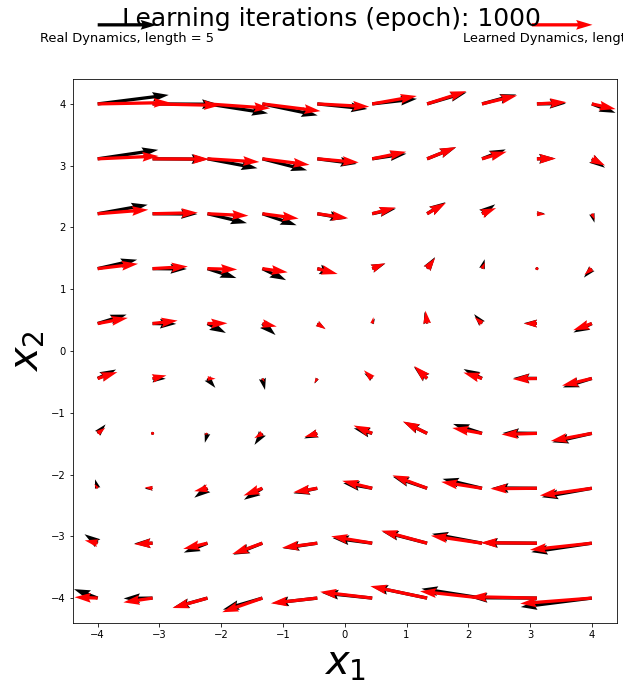

In [9]:
dyn_model.eval()


#Inputs
X1 = []
X2 = []
#output vects from true dynamics
Y1_train = []
Y2_train = []
#output vects from model
Y1_test = []
Y2_test = []

training_data = cls_obj.training_data #collect all the training data for quiver plot
for idx in range(len(training_data['inputs'])):
    X1.append(training_data['inputs'][idx].item(0))
    X2.append(training_data['inputs'][idx].item(1))
    Y1_train.append(training_data['outputs'][idx].item(0))
    Y2_train.append(training_data['outputs'][idx].item(1))
    #query the model
    curr_input = torch.from_numpy(training_data['inputs'][idx].T)
    curr_output = torch.from_numpy(training_data['outputs'][idx].T)
    model_output = dyn_model(curr_input)
    model_output_np = model_output.data.numpy()
    Y1_test.append(model_output_np.item(0))
    Y2_test.append(model_output_np.item(1))

#Plot the real dynamics first:
X1 = np.array(X1)
X2 = np.array(X2)
Y1_train = np.array(Y1_train)
Y2_train = np.array(Y2_train)
Y1_test = np.array(Y1_test)
Y2_test = np.array(Y2_test)


fig, ax = plt.subplots(figsize=(15,10))
qtrain = ax.quiver(X1, X2, Y1_train, Y2_train,color='k')
ax.quiverkey(qtrain, X=0.1, Y=1.1, U=5,
         label='Real Dynamics, length = 5', labelpos='S', fontproperties={'size':13})

qtest = ax.quiver(X1, X2, Y1_test, Y2_test,color='r')

ax.quiverkey(qtest, X=0.9, Y=1.1, U=5,
         label='Learned Dynamics, length = 5', labelpos='S', fontproperties={'size':13})

ax.set_xlabel('$x_1$',fontsize=40)
ax.set_ylabel('$x_2$',fontsize=40)
fig.suptitle("Learning iterations (epoch): %s"%epochs,fontsize=25)
ax.set_aspect('equal', adjustable='box')
# plt.show()